In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as mlt
import seaborn as sp
from torch.autograd import Variable
from torch import autograd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [193]:
%run Pre_process/Data_preprocess.ipynb
%run Model/Gan_model.ipynb
%run Model/Seq2seq.ipynb
%run Model/ConvGan.ipynb
%run Model/AutoEncoder.ipynb
%run train.ipynb
%run visualize.ipynb
%run test.ipynb
%run validation.ipynb

In [137]:
#pre_process_dataset("Data/Raw/boulder_2021.csv", 'boulder')
# pre_process_dataset("Data/Raw/sap.csv", 'sap')

In [206]:
#df = pd.read_csv(processed_data_csv)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
#df1 = pd.read_csv(processed_data_csv)
data1 = pd.read_csv("Data/Processed/acn_data_with_zero.csv")
data2 = pd.read_csv("Data/Processed/palo_alto_data_with_zero.csv")
data3 = pd.read_csv("Data/Processed/boulder_data_with_zero.csv")
data3 = data1.loc[(data1['Start'] >= '2019-01-01 00:00:00') & (data1['Start'] <= '2019-12-31 23:00:00')]
data2 = data2.loc[(data2['Start'] >= '2017-01-01 00:00:00') & (data2['Start'] <= '2018-01-01 23:00:00')]
data1 = data3.loc[(data3['Start'] >= '2018-01-02 00:00:00') & (data3['Start'] <= '2018-12-31 23:00:00')]
df = pd.concat([data2, data3, data1], axis=0).reset_index(drop=True)
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
input_size = df.shape[1]

In [207]:
# df = pd.read_csv("Data/Processed/sap_data_with_zero.csv")
# df = df.loc[(df['Start'] >= '2016-01-01 00:00:00')]
# plot_acf(df['Energy'], lags=100)  # Set the number of lags to display
# mlt.title('Autocorrelation Plot using statsmodels.graphics.tsaplots.plot_acf')
# mlt.show()

In [208]:
# df = pd.read_csv("Data/Raw/EV_data_corrected.csv")
# df['Energy'] = df['Charger_1'] + df['Charger_2'] + df['Charger_3'] + df['Charger_4']
# df.loc[:,'Day'] = pd.to_datetime(df['date_time']).dt.dayofweek + 1
# df = df.astype({'Day': 'int32'})
# df['Week Day'] = (df['Day'] <= 5).astype(int)
# df.rename(columns={'Day': 'Day of week'}, inplace=True)
# df['Year'] = pd.to_datetime(df['date_time']).dt.year
# df['Month'] = pd.to_datetime(df['date_time']).dt.month
# df['Day of month'] = pd.to_datetime(df['date_time']).dt.day
# df['Sum'] = df.groupby(pd.to_datetime(df['date_time']).dt.date)['Energy'].cumsum()
# df.drop(columns=['date_time', 'Charger_1', 'Charger_2', 'Charger_3', 'Charger_4'], inplace=True)
# df['Day of week'], df['Energy'] = df['Energy'].values, df['Day of week'].values
# new_column_order = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum']
# df.columns = new_column_order

In [209]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum'])
#df = pd.DataFrame(df, columns=['Energy'])

In [210]:
missing_train, real_train, mask_train, missing_test, real_test, mask_test = get_train_test_dataset(df, train_ratio)

In [211]:
step_per_epoch = len(missing_train) // batch_size

# Converting to tensor
real_train = torch.from_numpy(real_train).float().to(device)
missing_train = torch.from_numpy(missing_train).float().to(device)
mask_train = torch.from_numpy(mask_train).float().to(device)

# GAN Model

In [294]:
discriminator = Discriminator(input_size, hidden_size, 1).to(device)
generator = Generator(input_size, hidden_size, input_size).to(device)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = learning_rate)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate)

In [243]:
loss_function_MSE = nn.MSELoss()
loss_function = nn.BCELoss()

In [244]:
real_dataset, gen_dataset, errors_generator, errors_discriminator = train_Gan(generator, discriminator, optimizer_discriminator, optimizer_generator, loss_function, loss_function_MSE, real_train, missing_train, mask_train, step_per_epoch)

Epoch: 0 Loss D.: -125.35537719726562 Loss G.: -215.48025512695312 mmd: 8.96590518951416
Epoch: 1 Loss D.: -139.600830078125 Loss G.: -164.48056030273438 mmd: 8.544111251831055
Epoch: 2 Loss D.: -130.40245056152344 Loss G.: -124.21658325195312 mmd: 8.091058731079102
Epoch: 3 Loss D.: -89.44154357910156 Loss G.: -97.60786437988281 mmd: 7.687171936035156
Epoch: 4 Loss D.: -15.03717041015625 Loss G.: -83.17538452148438 mmd: 7.307519435882568
Epoch: 5 Loss D.: 84.1423110961914 Loss G.: -59.99785614013672 mmd: 7.738249778747559
Epoch: 6 Loss D.: 126.8655776977539 Loss G.: 61.50333786010742 mmd: 9.403059005737305
Epoch: 7 Loss D.: 62.384185791015625 Loss G.: 317.75811767578125 mmd: 11.351678848266602
Epoch: 8 Loss D.: -67.801513671875 Loss G.: 642.8941650390625 mmd: 13.224949836730957
Epoch: 9 Loss D.: -209.2713623046875 Loss G.: 952.09423828125 mmd: 14.902485847473145
Epoch: 10 Loss D.: -324.6866455078125 Loss G.: 1184.6591796875 mmd: 16.435766220092773
Epoch: 11 Loss D.: -415.7392578125 Lo

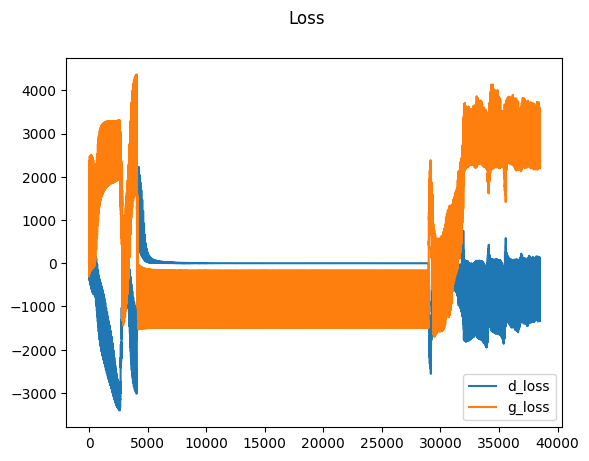

In [245]:
mlt.suptitle('Loss')
mlt.plot(errors_discriminator, label='d_loss')
mlt.plot(errors_generator, label='g_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

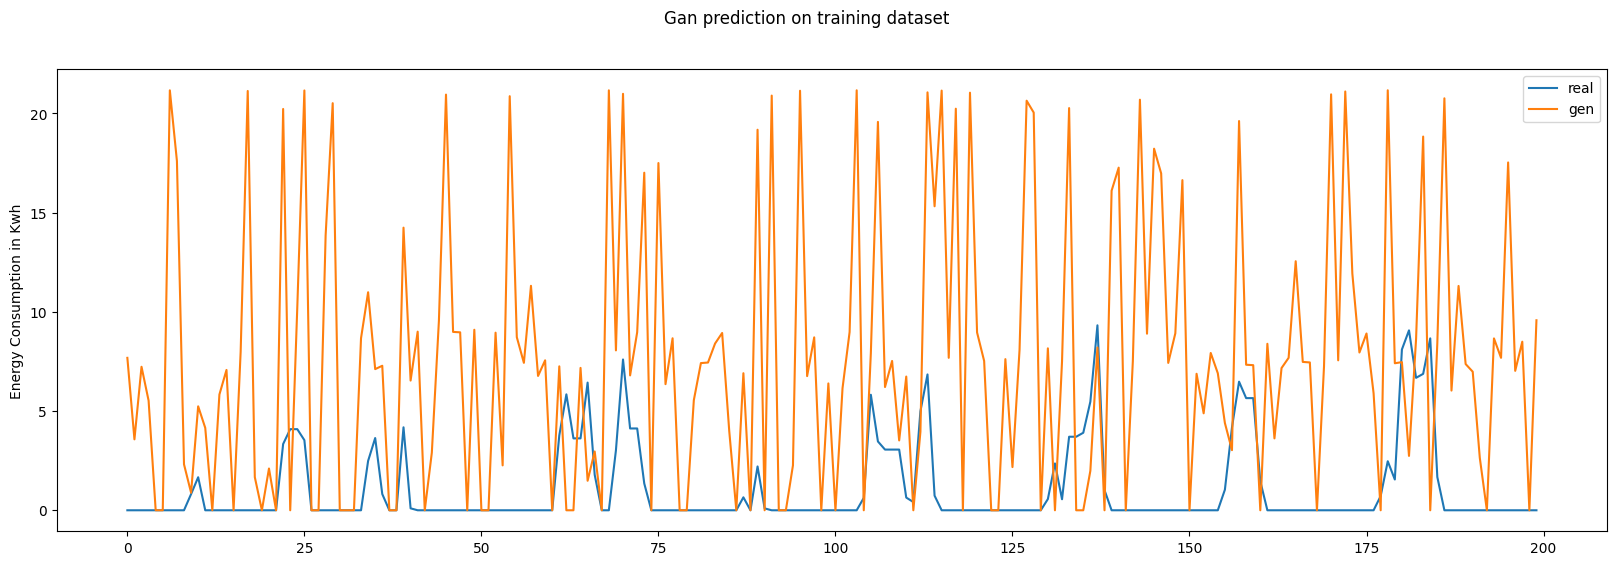

In [246]:
# test_gen_dataset = gen_dataset
tr = real_dataset[:200, -1, 0].view(-1)
te = gen_dataset[:200, -1, 0].view(-1)
mlt.figure(figsize=(20, 6))
mlt.suptitle('Gan prediction on training dataset')
plt.ylabel('Energy Consumption in Kwh')
mlt.plot(tr.detach().cpu().numpy(), label='real')
mlt.plot(te.detach().cpu().numpy(), label='gen')
mlt.legend()
#mlt.savefig('./Results/train_res_impute.png')
mlt.show()

In [247]:
ks_statistic, p_value = ks_2samp(tr.detach().cpu().numpy(), te.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.57
P-value: 2.4853853405237937e-30


In [1717]:
generator.eval()

Generator(
  (encoder_lstm): LSTM(1, 6, batch_first=True, bidirectional=True)
  (encoder_conv1): Conv1d(1, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchNorm1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_lstm): LSTM(18, 6, batch_first=True, bidirectional=True)
  (decoder_linear): Linear(in_features=12, out_features=1, bias=True)
  (activation): ReLU()
)

In [889]:
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution

# Generate random data from a normal distribution
random_data = np.random.normal(loc=mean, scale=std_dev, size=(batch_size, lag_size, 1))
#random_data = np.clip(random_data, 0, 1)
random_data = torch.tensor(random_data,dtype=torch.float32, requires_grad=True).to(device)

In [890]:
real_test = torch.from_numpy(real_test).float().to(device)
missing_test = torch.from_numpy(missing_test).float().to(device)
mask_test = torch.from_numpy(mask_test).float().to(device)

In [854]:
real_data, real_label = gen_real_batch(real_test.shape[0], 0, real_test)
z_input, mask_input = gen_z_input(batch_size, 0, missing_test, mask_test)

In [857]:
input_test = z_input + random_data

In [858]:
ttt = generator(input_test)

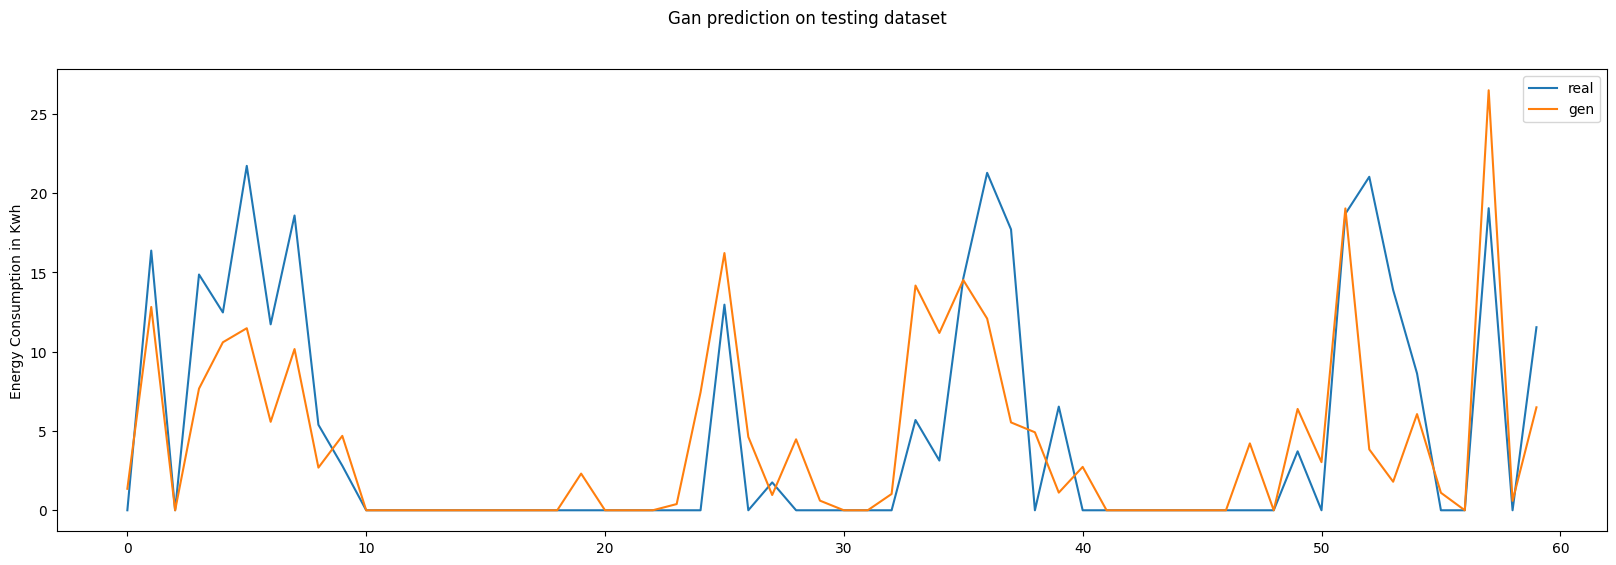

In [860]:
tr2 = z_input[:, -1, 0].view(-1)
te2 = ttt[:, -1, 0].view(-1)
# for i in range(len(te)):
#     te[i] = max(0, te[i])
#     if te[i] > 0:
#         te[i] = te[i] + 0.2
mlt.figure(figsize=(20, 6))
mlt.suptitle('Gan prediction on testing dataset')
mlt.plot(tr2.detach().cpu().numpy(), label='real')
mlt.plot(te2.detach().cpu().numpy(), label='gen')
plt.ylabel('Energy Consumption in Kwh')
mlt.legend()
#mlt.savefig('./Results/test_res_inpute.png')
mlt.show()

In [538]:
RMSE = mean_squared_error(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy(), squared=False)
print(f'RMSE:{RMSE}')

mae = mean_absolute_error(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy())
print("MSE:", mse)

RMSE:0.11749842017889023
MAE: 0.08268812
MSE: 0.013805878


In [539]:
RMSE = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy(), squared=False)
print(f'Test dataset RMSE:{RMSE}')

mae = mean_absolute_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MSE:", mse)

Test dataset RMSE:0.07364697009325027
MAE: 0.057413463
MSE: 0.005423876


In [861]:
ks_statistic, p_value = ks_2samp(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.23333333333333334
P-value: 0.07607524222884415


In [486]:
alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: The samples come from different distributions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the samples.")

Fail to reject the null hypothesis: There is no significant difference between the samples.


# Seq2Seq Conv

Trainning------------------------------------------------------------------------------------------------------------------------------

In [212]:
model = Seq2SeqConv1D(input_size, hidden_size, input_size).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function_seq2seq = nn.MSELoss()

In [213]:
real_dataset, gen_dataset, errors_generator, mask_data = train_Seq2Seq(model, optimizer, loss_function_seq2seq, real_train, missing_train, mask_train, step_per_epoch)

Epoch: 0 Loss G.: 21.74686622619629
Epoch: 1 Loss G.: 11.339762687683105
Epoch: 2 Loss G.: 10.441851615905762
Epoch: 3 Loss G.: 8.85079574584961
Epoch: 4 Loss G.: 6.916129112243652
Epoch: 5 Loss G.: 5.956989288330078
Epoch: 6 Loss G.: 5.287944793701172
Epoch: 7 Loss G.: 4.864047050476074
Epoch: 8 Loss G.: 4.504334926605225
Epoch: 9 Loss G.: 4.183081150054932
Epoch: 10 Loss G.: 3.8917348384857178
Epoch: 11 Loss G.: 3.6208224296569824
Epoch: 12 Loss G.: 3.344180107116699
Epoch: 13 Loss G.: 3.097191572189331
Epoch: 14 Loss G.: 2.8706283569335938
Epoch: 15 Loss G.: 2.7125096321105957
Epoch: 16 Loss G.: 2.608985424041748
Epoch: 17 Loss G.: 2.4855105876922607
Epoch: 18 Loss G.: 2.353487730026245
Epoch: 19 Loss G.: 2.2646238803863525
Epoch: 20 Loss G.: 2.1900458335876465
Epoch: 21 Loss G.: 2.0866198539733887
Epoch: 22 Loss G.: 1.988234043121338
Epoch: 23 Loss G.: 1.9237127304077148
Epoch: 24 Loss G.: 1.8355849981307983
Epoch: 25 Loss G.: 1.7923790216445923
Epoch: 26 Loss G.: 1.825403928756713

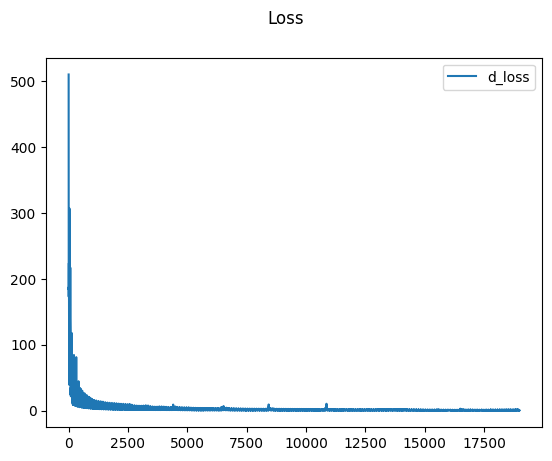

In [214]:
mlt.suptitle('Loss')
mlt.plot(errors_generator, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


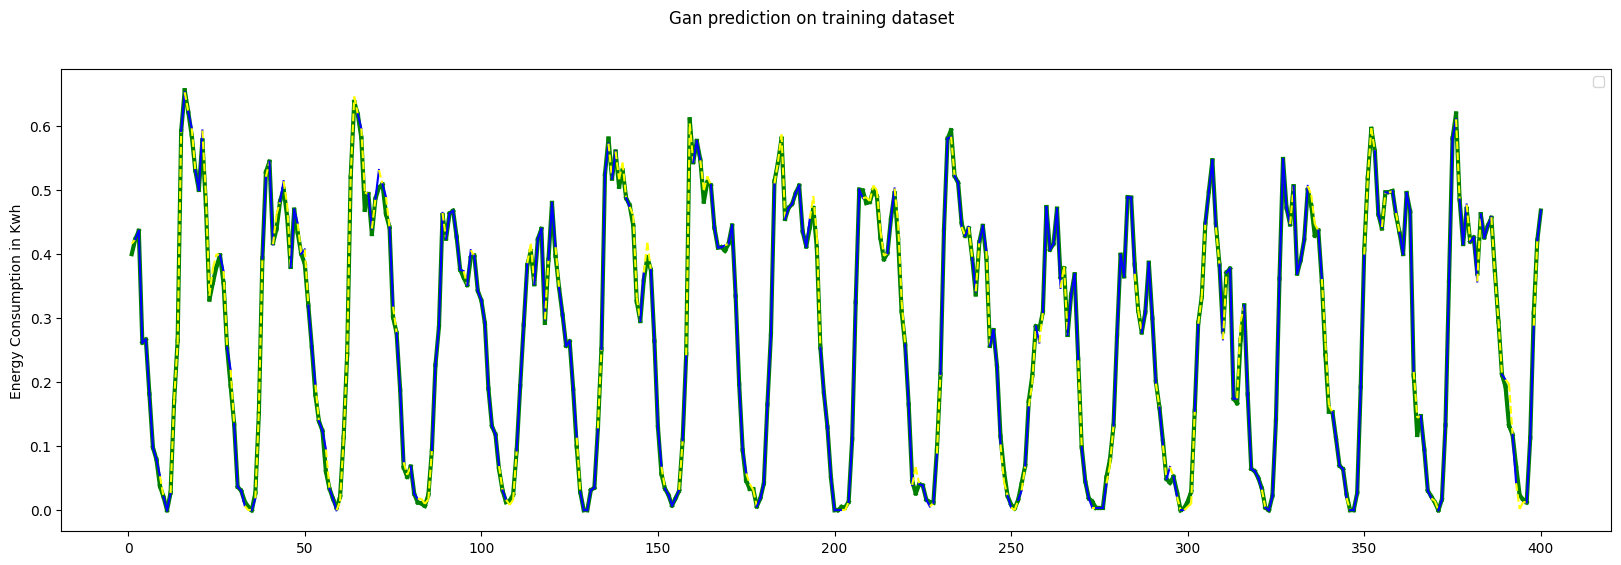

In [135]:
plot_imputation_results(real_dataset[:, -1, :].detach().cpu().numpy(), gen_dataset[:, -1, :].detach().cpu().numpy(), mask_data[:, -1, :].detach().cpu().numpy(), 900, 1300, 'Results/test2.png')

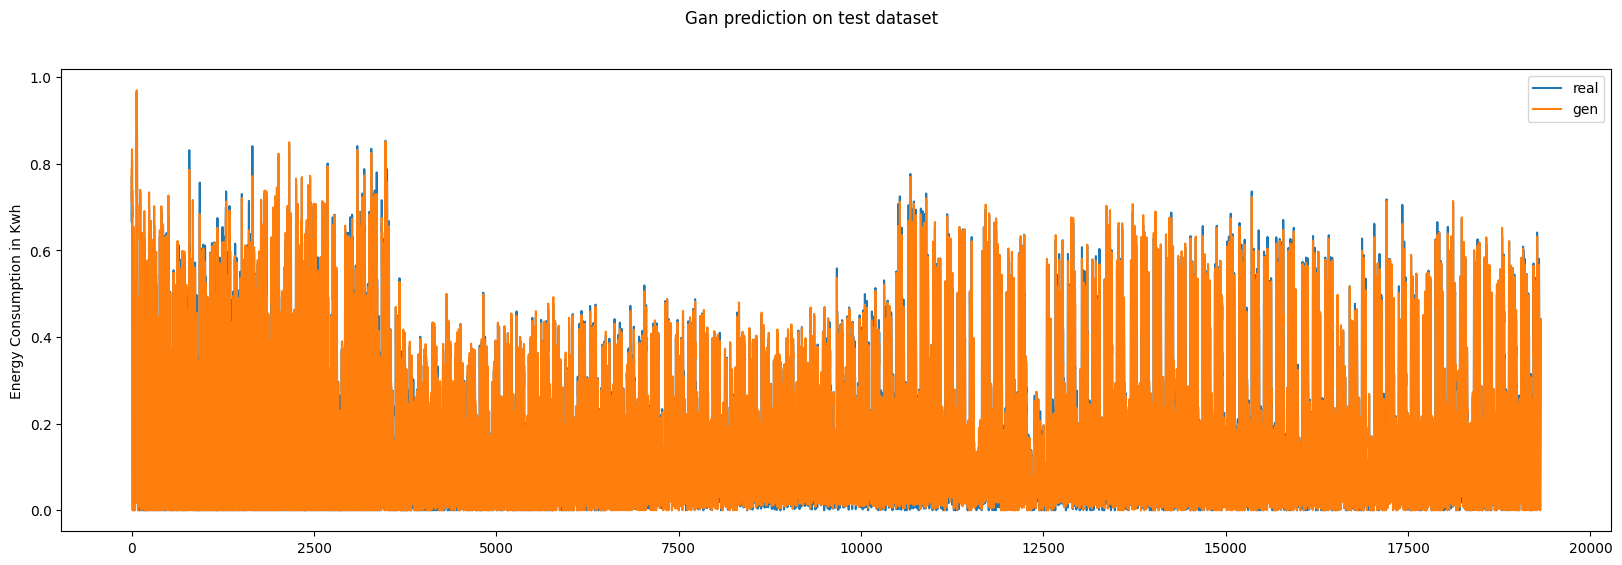

In [217]:
plot_full_dataset(real_dataset[:, -1, :].detach().cpu().numpy(), gen_dataset[:, -1, :].detach().cpu().numpy(), 5000, 155000, 'Results/test1.png')

In [218]:
tr = real_dataset[:, -1, 1].view(-1)
te = gen_dataset[:, -1, 1].view(-1)
ks_statistic, p_value = ks_2samp(tr.detach().cpu().numpy(), te.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.014226973684210525
P-value: 0.01442197273596975


Testing-------------------------------------------------------------------------------------------------------------------------------

In [267]:
df = pd.read_csv("Data/Processed/sap_data_with_zero.csv")
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum'])

Grenobile data

In [268]:
# df = pd.read_csv("Data/Raw/EV_data_corrected.csv")
# df['Energy'] = df['Charger_1'] + df['Charger_2'] + df['Charger_3'] + df['Charger_4']
# df.loc[:,'Day'] = pd.to_datetime(df['date_time']).dt.dayofweek + 1
# df = df.astype({'Day': 'int32'})
# df['Week Day'] = (df['Day'] <= 5).astype(int)
# df.rename(columns={'Day': 'Day of week'}, inplace=True)
# df['Year'] = pd.to_datetime(df['date_time']).dt.year
# df['Month'] = pd.to_datetime(df['date_time']).dt.month
# df['Day of month'] = pd.to_datetime(df['date_time']).dt.day
# df['Sum'] = df.groupby(pd.to_datetime(df['date_time']).dt.date)['Energy'].cumsum()
# df.drop(columns=['date_time', 'Charger_1', 'Charger_2', 'Charger_3', 'Charger_4'], inplace=True)
# df['Day of week'], df['Energy'] = df['Energy'].values, df['Day of week'].values
# new_column_order = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum']
# df.columns = new_column_order

In [269]:

missing_train, real_train, mask_train, missing_test, real_test, mask_test = get_train_test_dataset(df, train_ratio)

In [270]:
real_test = real_test[: -(real_test.shape[0] % batch_size)]
missing_test = missing_test[: -(missing_test.shape[0] % batch_size)]
mask_test = mask_test[: -(mask_test.shape[0] % batch_size)]

In [271]:
step_per_epoch = len(missing_test) // batch_size

In [272]:
# tr = df['Energy']
# mlt.figure(figsize=(20, 6))
# mlt.suptitle('Gan prediction on test dataset')
# mlt.ylabel('Energy Consumption in Kwh')
# mlt.plot(tr, label='real')
# mlt.legend()
# mlt.show()

In [273]:
real_test = torch.from_numpy(real_test).float().to(device)
missing_test = torch.from_numpy(missing_test).float().to(device)
mask_test = torch.from_numpy(mask_test).float().to(device)

In [274]:
real_dataset_test_seq2seq, imputed_dataset, loss, mask_test_result = test_model(model, real_test, missing_test, mask_test, loss_function_seq2seq, step_per_epoch)

In [275]:
real_dataset_test_seq2seq2 = real_dataset_test_seq2seq[:, -1, :]
imputed_dataset2 = imputed_dataset[:, -1, :]

In [276]:
real_dataset_test_seq2seq = pd.DataFrame(real_dataset_test_seq2seq[:, -1, :].detach().cpu().numpy(), columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum'])
real_dataset_test_seq2seq = scaler.inverse_transform(real_dataset_test_seq2seq)
real_dataset_test_seq2seq = torch.tensor(real_dataset_test_seq2seq)

In [277]:
imputed_dataset = pd.DataFrame(imputed_dataset[:, -1, :].detach().cpu().numpy(), columns=['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum'])
imputed_dataset = scaler.inverse_transform(imputed_dataset)
imputed_dataset = torch.tensor(imputed_dataset)

In [278]:
real_dataset_test_seq2seq[:,1].max()

tensor(296.1513)

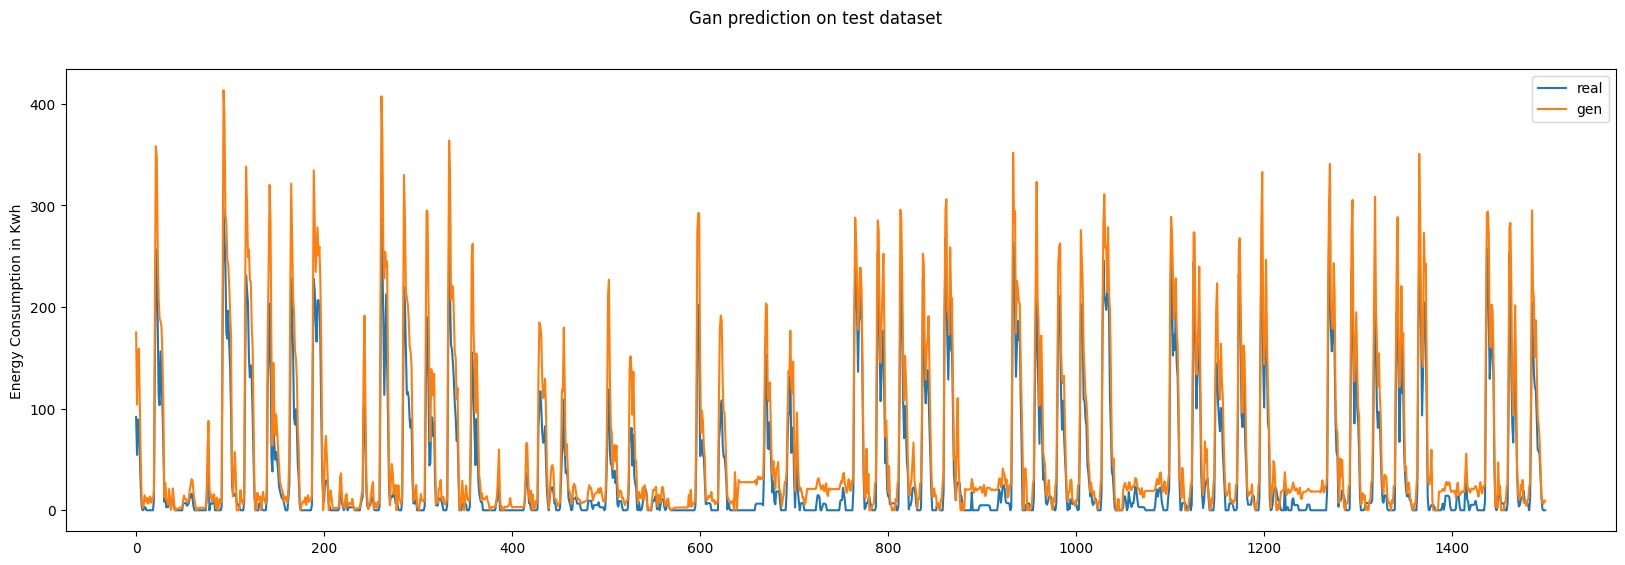

In [280]:
plot_full_dataset(real_dataset_test_seq2seq.detach().cpu().numpy(), imputed_dataset.detach().cpu().numpy(), 000, 1500, 'Results/test3.png')

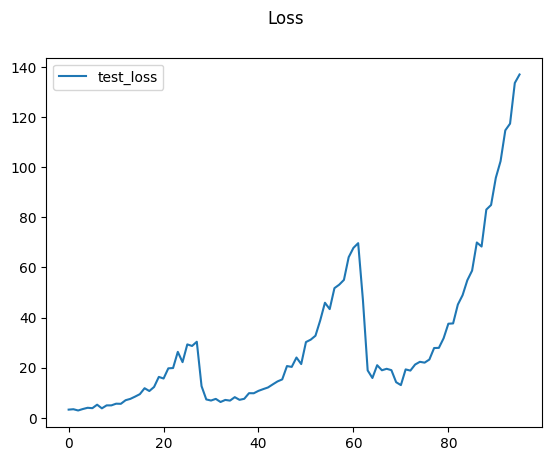

In [250]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

Evaluation----------------------------------------------------------------------------------------------------------------

In [251]:
validation_matrix(real_dataset_test_seq2seq.detach().cpu().numpy(), imputed_dataset.detach().cpu().numpy(), mask_test_result[:, -1, :].detach().cpu().numpy())

RMSE:10.159200668334961
MAE: 8.04447
MSE: 103.20935
R-squared: 0.9156770489960278
MAE: tensor(8.0445)
RMSE:10.159200668334961
R-squared: tensor(0.9157)


# Conv Gan

In [622]:
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution

# Generate random data from a normal distribution
random_data = np.random.normal(loc=mean, scale=std_dev, size=(real_train.size()))
#random_data = np.clip(random_data, 0, 1)
random_data = torch.tensor(random_data,dtype=torch.float32, requires_grad=True).to(device)

In [623]:
loss_function = nn.BCELoss()
generator = ConvGenerator(input_size, hidden_size, input_size).to(device)
discriminator = ConvDiscriminator(input_size, hidden_size).to(device)
optimizer_discriminator = torch.optim.RMSprop(discriminator.parameters(), lr = learning_rate)
optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr = learning_rate)

In [652]:
real_dataset, gen_dataset, errors_generator, errors_discriminator, mask_results = train_ConvGan(generator, discriminator, optimizer_discriminator, optimizer_generator, loss_function, real_train, missing_train, mask_train, step_per_epoch, random_data)

Epoch: 0 Loss D.: 1.4761223354753383e-09 Loss G.: 70198.734375
Epoch: 1 Loss D.: 4.968448763520428e-09 Loss G.: 80611.6015625
Epoch: 2 Loss D.: 3.0461211331100913e-09 Loss G.: 79788.3828125
Epoch: 3 Loss D.: 1.8198056395135609e-09 Loss G.: 69518.578125
Epoch: 4 Loss D.: 4.084095728273951e-09 Loss G.: 80406.6328125
Epoch: 5 Loss D.: 5.117372303686807e-09 Loss G.: 79452.9453125
Epoch: 6 Loss D.: 2.900419815432542e-07 Loss G.: 70457.5703125
Epoch: 7 Loss D.: 1.1794101340001362e-07 Loss G.: 81826.5625
Epoch: 8 Loss D.: 6.401780439091453e-08 Loss G.: 78961.9453125
Epoch: 9 Loss D.: 4.010999887782418e-08 Loss G.: 70463.0703125
Epoch: 10 Loss D.: 2.4900037587372026e-08 Loss G.: 80600.640625
Epoch: 11 Loss D.: 1.732365717543871e-08 Loss G.: 78651.375
Epoch: 12 Loss D.: 1.2863818454889042e-08 Loss G.: 69626.046875
Epoch: 13 Loss D.: 9.594832484083327e-09 Loss G.: 81047.109375
Epoch: 14 Loss D.: 6.3423470919588e-09 Loss G.: 78649.890625
Epoch: 15 Loss D.: 5.379826806262145e-09 Loss G.: 69791.375

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


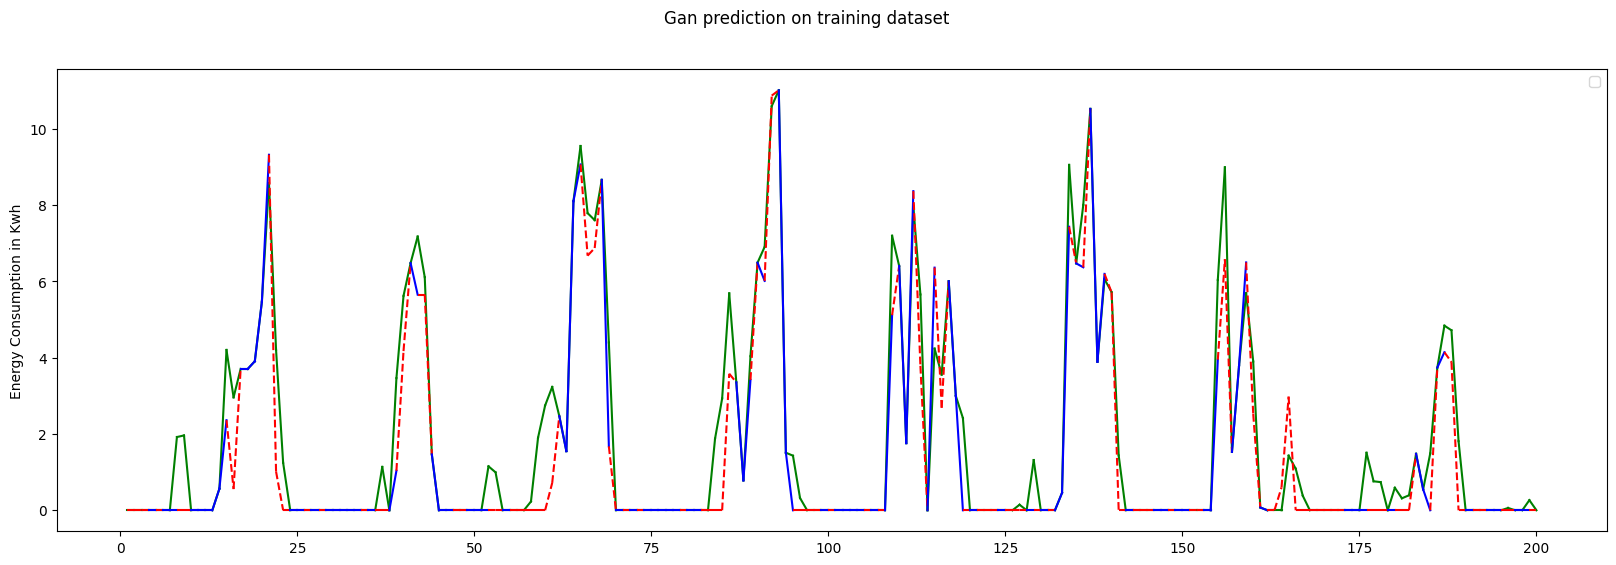

In [519]:
plot_imputation_results(real_dataset, gen_dataset, mask_results,100,300)

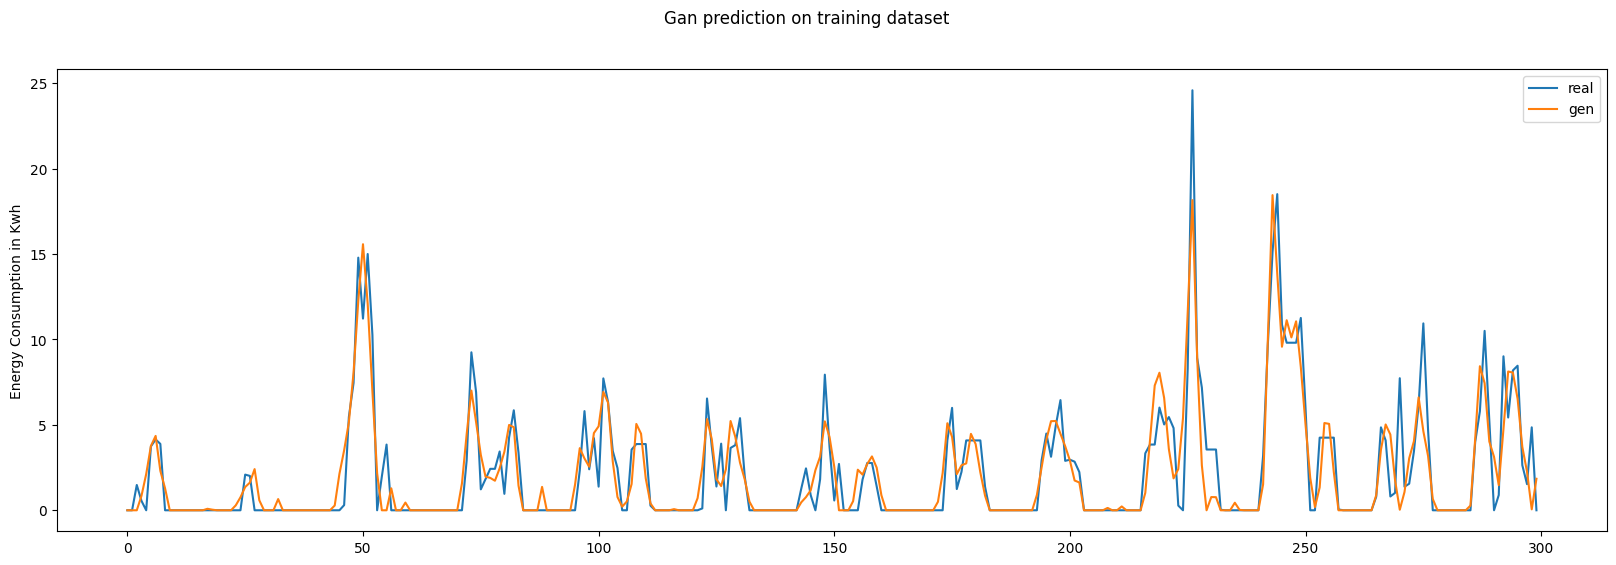

In [660]:
plot_full_dataset(real_dataset, gen_dataset, 300, 600, 3)

In [663]:
tr = real_dataset[:, 7, 0]
te = gen_dataset[:, 7, 0]
ks_statistic, p_value = ks_2samp(tr.detach().cpu().numpy(), te.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.042658730158730174
P-value: 3.4487820648532785e-13


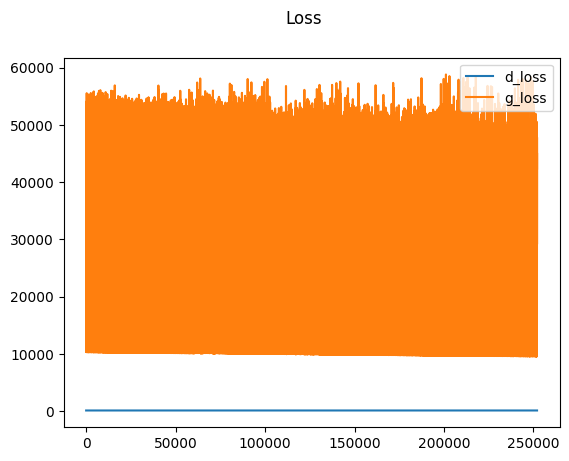

In [485]:
mlt.suptitle('Loss')
mlt.plot(errors_discriminator, label='d_loss')
mlt.plot(errors_generator, label='g_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

In [520]:
RMSE = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy(), squared=False)
print(f'RMSE:{RMSE}')

mae = mean_absolute_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MSE:", mse)

RMSE:1.9196507930755615
MAE: 1.2201656
MSE: 3.685059


In [538]:
random_noise_test = torch.tensor(np.random.randn(real_test.shape[0], lag_size, input_size), dtype=torch.float32, requires_grad=True).to(device)

In [548]:
real_test = torch.from_numpy(real_test).float().to(device)

In [549]:
generator.eval()

ConvGenerator(
  (lstm1): LSTM(1, 12, batch_first=True)
  (batchNorm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (batchNorm2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(1, 12, batch_first=True)
  (batchNorm3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=12, out_features=1, bias=True)
  (activation): ReLU()
)

In [550]:
real_data_test_conv, real_label_test_conv = gen_real_batch(real_test.shape[0], 0, real_test)

In [551]:
test_res = generator(real_data_test_conv, random_noise_test)

In [552]:
tr_test = real_data_test_conv[:, -1, 0]
te_test = test_res[:, -1, 0]
ks_statistic_test, p_value_test = ks_2samp(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic_test)
print("P-value:", p_value_test)

KS Statistic: 0.09915702243177597
P-value: 2.3336990538201477e-30


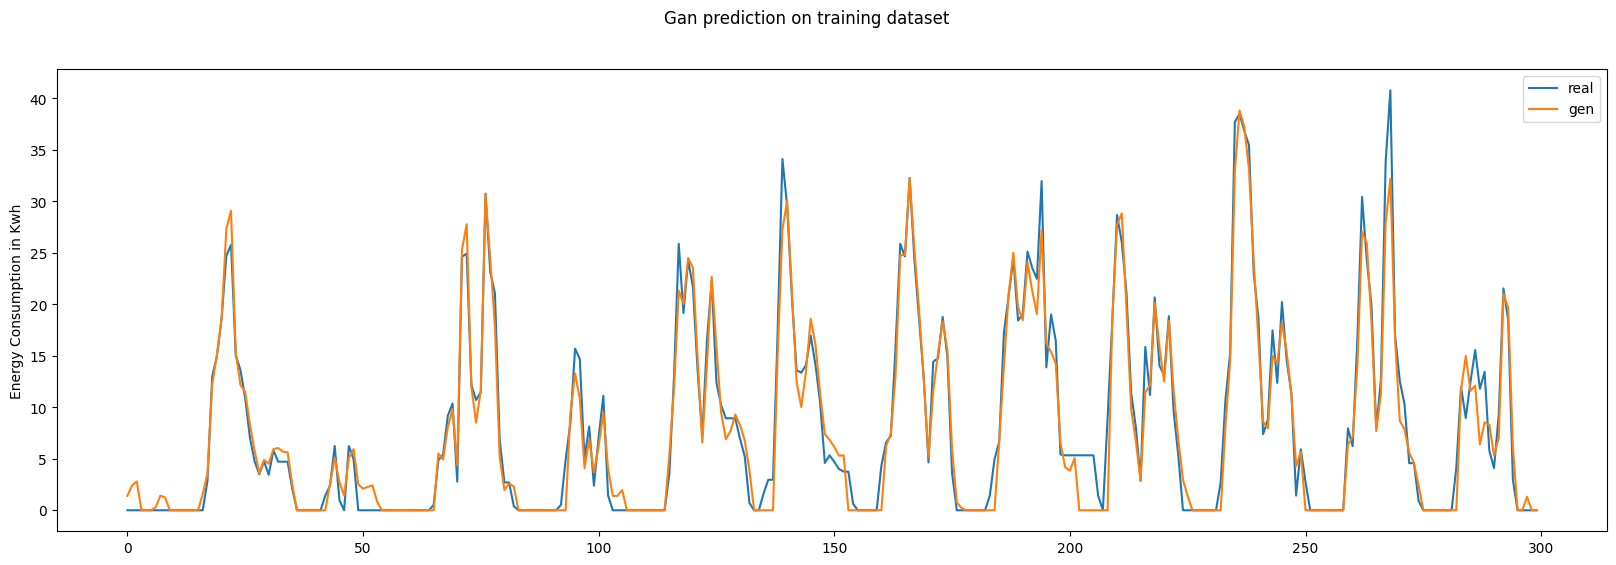

In [554]:
plot_full_dataset(real_data_test_conv, test_res, 300, 600, -1)

In [555]:
RMSE = mean_squared_error(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy(), squared=False)
print(f'RMSE:{RMSE}')

mae = mean_absolute_error(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy())
print("MSE:", mse)

RMSE:1.6283469200134277
MAE: 0.9829012
MSE: 2.6515138


# Auto Encoder Model

In [289]:
model = VAE(input_size, hidden_size, 14).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function_autoencoder = nn.MSELoss()

In [290]:
real_dataset, gen_dataset, errors_generator, mask_data = train_autoEncoder(model, optimizer, loss_function_autoencoder, real_train, missing_train, mask_train, step_per_epoch)

Epoch: 0 Loss G.: 0.43358471989631653
Epoch: 1 Loss G.: 0.3890153765678406
Epoch: 2 Loss G.: 0.3458567261695862
Epoch: 3 Loss G.: 0.2933838665485382
Epoch: 4 Loss G.: 0.24170495569705963
Epoch: 5 Loss G.: 0.22644130885601044
Epoch: 6 Loss G.: 0.2227267175912857
Epoch: 7 Loss G.: 0.21392427384853363
Epoch: 8 Loss G.: 0.20765644311904907
Epoch: 9 Loss G.: 0.20507539808750153
Epoch: 10 Loss G.: 0.20348504185676575
Epoch: 11 Loss G.: 0.1948549747467041
Epoch: 12 Loss G.: 0.19183574616909027
Epoch: 13 Loss G.: 0.19107408821582794
Epoch: 14 Loss G.: 0.18620029091835022
Epoch: 15 Loss G.: 0.18494553864002228
Epoch: 16 Loss G.: 0.18235166370868683
Epoch: 17 Loss G.: 0.18085232377052307
Epoch: 18 Loss G.: 0.17969532310962677
Epoch: 19 Loss G.: 0.17869432270526886
Epoch: 20 Loss G.: 0.17873303592205048
Epoch: 21 Loss G.: 0.1784922033548355
Epoch: 22 Loss G.: 0.17850972712039948
Epoch: 23 Loss G.: 0.17719101905822754
Epoch: 24 Loss G.: 0.1772044450044632
Epoch: 25 Loss G.: 0.17722739279270172
Epo

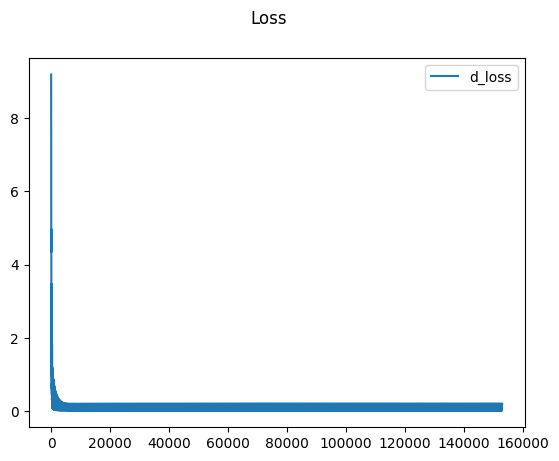

In [278]:
mlt.suptitle('Loss')
mlt.plot(errors_generator, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

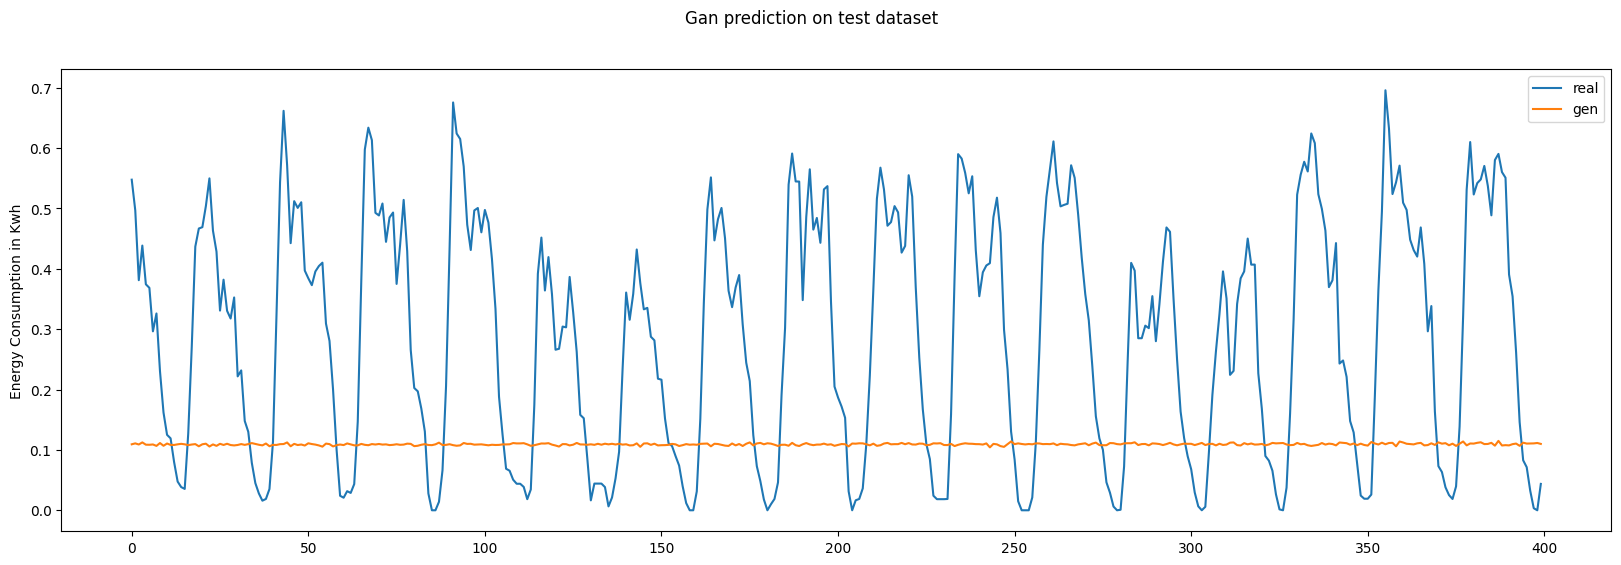

In [279]:
plot_full_dataset(real_dataset[:, -1, :].detach().cpu().numpy(), gen_dataset[:, -1, :].detach().cpu().numpy(), 200, 600, 'Results/test1.png')